<a href="https://colab.research.google.com/github/yoouza/bigcontest/blob/master/estimation/News_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mxnet-cu101
!pip install gluonnlp pandas tqdm
!pip install sentencepiece==0.1.85
!pip install transformers==2.1.1
!pip install torch==1.3.1
!pip install tensorflow

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git

In [4]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import gluonnlp as nlp
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns

from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, tqdm_notebook

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from transformers import AdamW
from transformers.optimization import WarmupLinearSchedule
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [6]:
#GPU 사용
device = torch.device("cuda:0")

# **뉴스 예측**

## **모델 불러오기**

In [7]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [8]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [9]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [10]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2, # 해당 부분 파라미터 조정으로 다중 분류 가능
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [11]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [12]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [13]:
optimizer = AdamW(optimizer_grouped_parameters, lr=0)
loss_fn = nn.CrossEntropyLoss()

In [14]:
load_model = '/content/drive/My Drive/Bigcon/2020빅콘테스트 문제데이터(혁신아이디어분야)/분석 모델/model_checkpoint/all.tar'
state_dict = '/content/drive/My Drive/Bigcon/2020빅콘테스트 문제데이터(혁신아이디어분야)/분석 모델/model_checkpoint/model_state_dict.pt'

In [ ]:
checkpoint = torch.load(load_model)
model.load_state_dict(torch.load(state_dict))
model.eval()

## **데이터 불러오기**

In [16]:
data_path = '/content/drive/My Drive/Bigcon/2020빅콘테스트 문제데이터(혁신아이디어분야)/전처리한 데이터/news_data.csv'

In [17]:
news_data = pd.read_csv(data_path, encoding='utf-8', index_col=0)
news_data.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,date,content,label
0,2019-02-01,EU 집행위 조사관 4일 폴란드 도착…유통 소고기 회수중 김병수 특파원 김서영 기...,10
1,2019-02-01,병든 소를 도축하는 폴란드 도축장 영상 유럽연합 행정부 격인 집행위원회는 1일 폴...,10
2,2019-02-01,EU 집행위 대변인은 이날 브리핑에서 폴란드 당국이 소고기 가공공장을 폐쇄하고 시장...,10
3,2019-02-01,"문제의 소고기가 수출된 것으로 확인된 나라는 에스토니아, 핀란드, 프랑스, 독일, ...",10
4,2019-02-01,앞서 영국 BBC 방송은 폴란드의 한 도축장에서 도축된 병든 소가 프랑스와 독일 등...,10


In [18]:
predict_dataset = []
for i in tqdm(range(len(news_data))):
    predict_dataset.append([news_data['content'][i]])
len(predict_dataset)

100%|██████████| 2177911/2177911 [00:57<00:00, 37697.17it/s]


2177911

In [19]:
transform = nlp.data.BERTSentenceTransform(tok, max_seq_length=64, pad=True, pair=False)
sentences = [transform(i) for i in predict_dataset]

In [20]:
predict_dataloader = torch.utils.data.DataLoader(sentences, batch_size=1, num_workers=10)

## **뉴스 예측**

In [ ]:
result_out = []
for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm_notebook(predict_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    out = model(token_ids, valid_length, segment_ids)
    max_vals, max_indices = torch.max(out, 1)
    result_out.append(max_indices)
len(result_out)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
# 예측 결과
predict = []
for i in tqdm(result_out):
    predict.append(i.item())
predict[:5]

In [ ]:
news_data['predict'] = predict
news_data.head()

In [ ]:
news_predict = news_data.groupby(news_data['date']).mean(['predict'])
news_predict.head()

# **예측 결과 시각화**

In [ ]:
card_2019 = pd.read_csv('/home/lab12/workspace/bigcontest/estimation/Data_Set/card_std_2019.csv') # 정규화 데이터 스케일 (0, 1)
card_2020 = pd.read_csv('/home/lab12/workspace/bigcontest/estimation/Data_Set/card_std_2020.csv') # 정규화 데이터 스케일 (0, 1)
card_2019.head(), card_2020.head()

(       STD_DD  USE_AMT_SCALE        10        20     30_32     35_52  \
 0  2019-02-01       0.738975  0.005678  0.243673  0.400330  0.453441   
 1  2019-02-02       0.861667  0.086725  0.619404  0.378784  0.478584   
 2  2019-02-03       0.519572  0.024936  0.360050  0.074052  0.310767   
 3  2019-02-04       0.353293  0.057899  0.299347  0.061732  0.162227   
 4  2019-02-05       0.000000  0.063091  0.102011  0.000000  0.000000   
 
          40        42        44        80        81  
 0  0.593767  0.483717  0.257389  0.705633  0.839713  
 1  0.824538  0.690112  0.451217  0.725208  1.000000  
 2  0.677886  0.328310  0.211883  0.476869  0.826794  
 3  0.451341  0.213189  0.189089  0.257077  0.712459  
 4  0.000000  0.000000  0.000000  0.000000  0.000000  ,
          date  news_predict
 0  2019-02-01      0.555328
 1  2019-02-02      0.628405
 2  2019-02-03      0.658620
 3  2019-02-04      0.676389
 4  2019-02-05      0.875455)

In [ ]:
card_data = pd.concat([card_2019, card_2020], axis=0)

In [ ]:
data = pd.concat([card_data, predict_2019['news_predict']], axis=1)
data

,STD_DD,USE_AMT_SCALE,10,20,30_32,35_52,40,42,44,80,81,news_predict
0,2019-02-08,0.719157,0.198486,0.190938,0.540798,0.315464,0.643225,0.471572,0.428294,0.622950,0.288378,0.555328
1,2019-02-09,0.850184,0.441347,0.501920,0.472395,0.423434,0.856923,0.656224,0.508419,0.713549,0.261301,0.628405
2,2019-02-10,0.506820,0.380923,0.462646,0.428588,0.117193,0.665350,0.497054,0.391618,0.411982,0.119666,0.658620
3,2019-02-11,0.548325,0.233486,0.128264,0.611444,0.326361,0.390601,0.356915,0.329937,0.365736,0.215180,0.676389
4,2019-02-12,0.559256,0.114950,0.101877,0.514592,0.301761,0.434399,0.374596,0.311532,0.444580,0.203158,0.875455
5,2019-02-13,0.562650,0.058347,0.124459,0.371582,0.311140,0.439016,0.352400,0.311754,0.513566,0.271358,0.859984
6,2019-02-14,0.604200,0.014619,0.136668,0.502995,0.331012,0.472430,0.436747,0.340481,0.591843,0.277479,0.659197
7,2019-02-15,0.638268,0.162245,0.104525,0.320626,0.307148,0.476380,0.419193,0.298623,0.640697,0.281773,0.327035
8,2019-02-16,0.821226,0.315686,0.444573,0.499245,0.410679,0.769464,0.716552,0.475683,0.818034,0.349786,0.629485
9,2019-02-17,0.497352,0.367403,0.480371,0.372800,0.273822,0.609969,0.404841,0.268834,0.472358,0.144584,0.617926


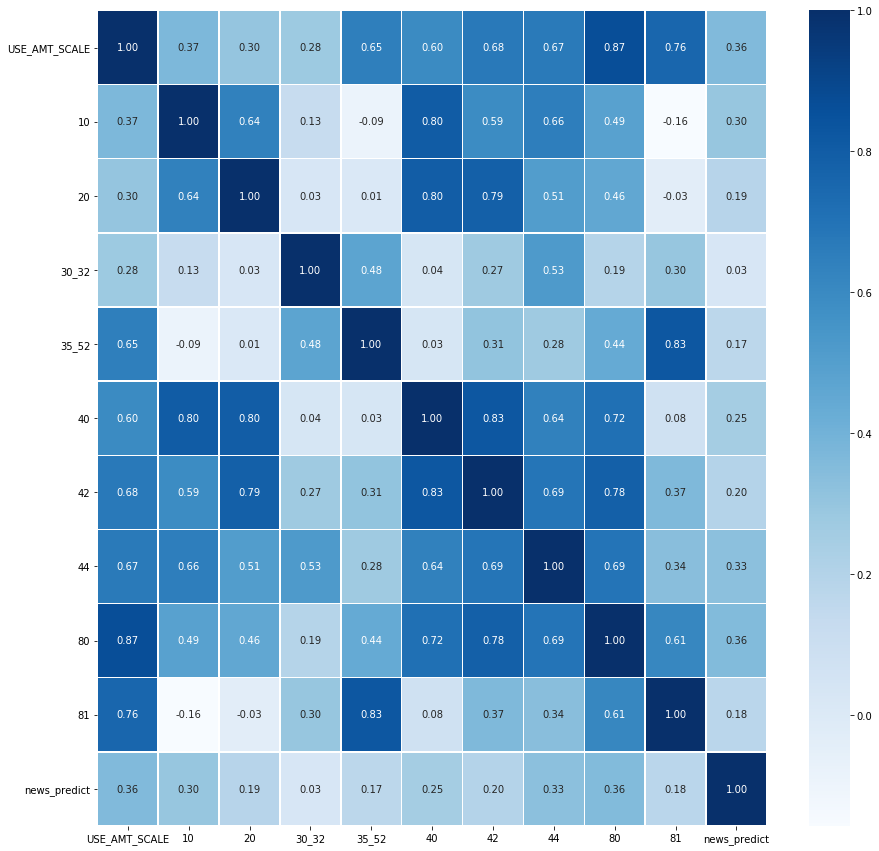

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data = data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')